![digitizing_team](digitizing_team.png)


DigiNsure Inc. is an innovative insurance company focused on enhancing the efficiency of processing claims and customer service interactions. Their newest initiative is digitizing all historical insurance claim documents, which includes improving the labeling of some IDs scanned from paper documents and identifying them as primary or secondary IDs.

To help them in their effort, you'll be using multi-modal learning to train an Optical Character Recognition (OCR) model. To improve the classification, the model will use **images** of the scanned documents as input and their **insurance type** (home, life, auto, health, or other). Integrating different data modalities (such as image and text) enables the model to perform better in complex scenarios, helping to capture more nuanced information. The **labels** that the model will be trained to identify are of two types: a primary and a secondary ID, for each image-insurance type pair.

In [14]:
! pip install torchvision

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python3 -m pip install --upgrade pip


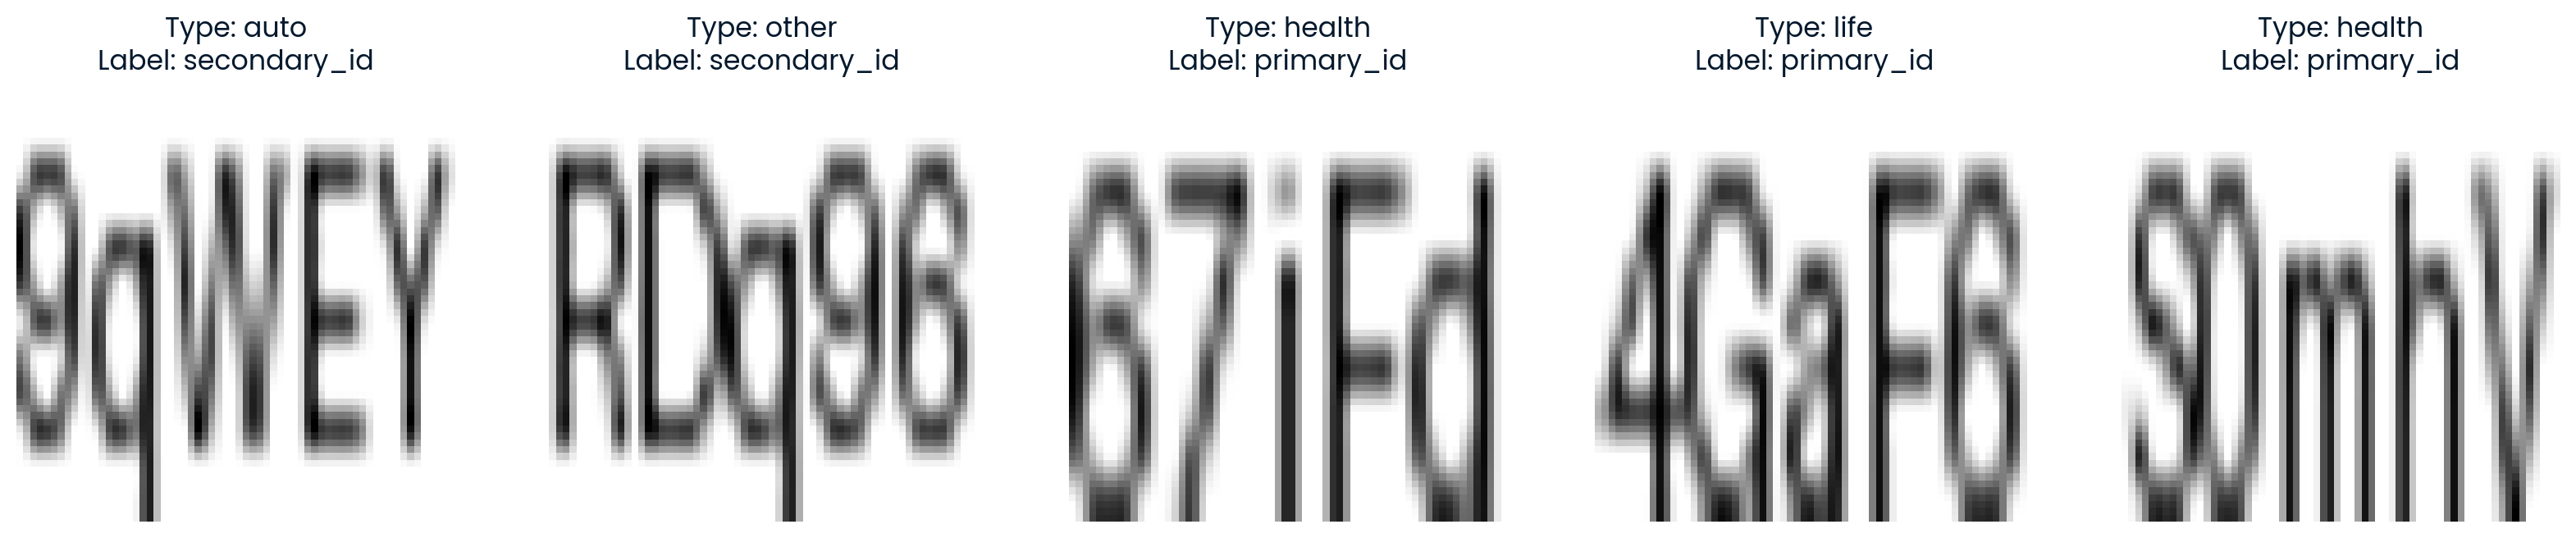

In [15]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from project_utils import ProjectDataset
import pickle 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Load the data
dataset = pickle.load(open('ocr_insurance_dataset.pkl', 'rb'))

# Define a function to visualize codes with their corresponding types and labels 
def show_dataset_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, min(num_images, len(dataset)), figsize=(20, 4))
    for ax, idx in zip(axes, np.random.choice(len(dataset), min(num_images, len(dataset)), False)):
        img, lbl = dataset[idx]
        ax.imshow((img[0].numpy() * 255).astype(np.uint8).reshape(64,64), cmap='gray'), ax.axis('off')
        ax.set_title(f"Type: {list(dataset.type_mapping.keys())[img[1].tolist().index(1)]}\nLabel: {list(dataset.label_mapping.keys())[list(dataset.label_mapping.values()).index(lbl)]}")
    plt.show()

# Inspect 5 codes images from the dataset
show_dataset_images(dataset)

In [16]:
# Start coding here 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class OCRModel(nn.Module):
    def __init__(self, num_insurance_types):
        super(OCRModel, self).__init__()
        
        # Image Processing Layer
        self.image_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Feature Flattening
        self.flatten = nn.Flatten()
        
        # Fully Connected Layer for Image Features
        self.image_fc = nn.Linear(64 * 8 * 8, 256)

        # Insurance Type Processing Layer
        self.type_layer = nn.Linear(num_insurance_types, 128)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(256 + 128, 128),
            nn.ReLU(),
            nn.Linear(128, 2),  # Output: 2 classes (Primary or Secondary ID)
            nn.Softmax(dim=1)
        )

    def forward(self, image, insurance_type):
        # Image processing
        image_features = self.image_layer(image)  # Convolutional layers
        image_features = self.flatten(image_features)  # Flatten
        image_features = F.relu(self.image_fc(image_features))  # Fully connected
        
        # Insurance type processing
        type_features = F.relu(self.type_layer(insurance_type))  # Process insurance type

        # Fusion and classification
        combined_features = torch.cat((image_features, type_features), dim=1)
        output = self.classifier(combined_features)

        return output
    

    
# Define the model
num_insurance_types = 5  # Example: home, life, auto, health, other
model = OCRModel(num_insurance_types)

# Define optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define loss function (Cross-Entropy)
criterion = nn.CrossEntropyLoss()



batch_size = 64
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for images, labels in train_loader:
        # Separate image and insurance type inputs
        image_input = images[0].to(device)  # Image tensor (batch_size, 1, 64, 64)
        insurance_input = images[1].to(device)  # Insurance type tensor (batch_size, num_insurance_types)
        labels = labels.to(device)  # Labels (Primary = 0, Secondary = 1)
        
        # Forward pass
        outputs = model(image_input, insurance_input)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track loss
        running_loss += loss.item()
    
    # Print epoch loss
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("Training complete!")



Epoch [1/10], Loss: 0.6948
Epoch [2/10], Loss: 0.7057
Epoch [3/10], Loss: 0.6918
Epoch [4/10], Loss: 0.6912
Epoch [5/10], Loss: 0.6915
Epoch [6/10], Loss: 0.6897
Epoch [7/10], Loss: 0.6904
Epoch [8/10], Loss: 0.6895
Epoch [9/10], Loss: 0.6884
Epoch [10/10], Loss: 0.6869
Training complete!
